# Power in Harmonics

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from calcwf import total2chirp

/home/ben.patterson/.conda/envs/eccentric_harmonics/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/eccentric_harmonics/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


We can look at the power in each harmonic at different parts of parameter space by match filtering the harmonics against an eccentric waveform with the same parameters. We plot the results below.

In [2]:
# Load in data
with open(os.path.join('harm_power_data', 'all_matches'), 'rb') as fp:
        grid_data = pickle.load(fp)

# Find min and max
for param in list(grid_data.keys()):
    for key in list(grid_data[param].keys()):
        if key not in ['params', 'vary_param', 'param_vals'] and 'phase' not in key:
            grid_data[param][f'{key}_max'] = np.nanmax(np.array(grid_data[param][key]), axis=1)
            grid_data[param][f'{key}_min'] = np.nanmin(np.array(grid_data[param][key]), axis=1)
grid_data['vary_q']['param_vals'] = 1/grid_data['vary_q']['param_vals']

In [3]:
def fixed_params(data, vary_param):
    param_dict = {'e': f'{data["e"]:.1f}', 'chirp': f'{total2chirp(data["M"], data["q"]):.0f}~M_\odot', 'q': f'{1/data["q"]:.1f}'}
    param_text = {'e': '$e_{10}$', 'chirp': '$\\mathcal{M}$', 'q': '$q$'}
    keys = list(param_dict.keys())
    keys.remove(vary_param.split('_')[-1])
    return [[param_text[key], param_dict[key]] for key in keys]

/tmp/ipykernel_3610758/425660706.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


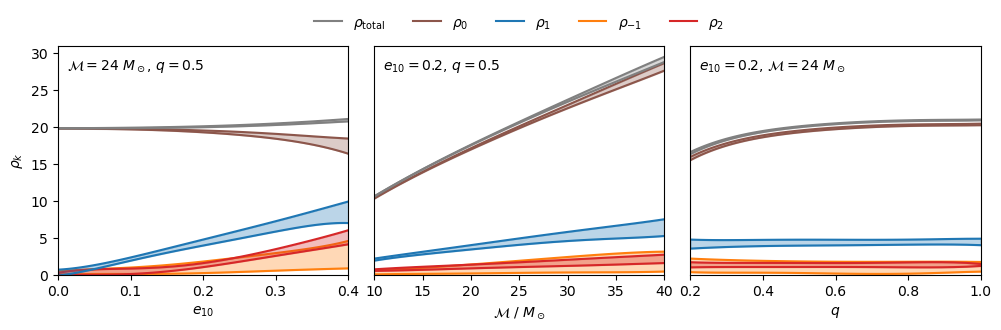

In [4]:
# Panel settings
xlims = [(0,0.4), (10,40), (0.2,1)]
xlabels = ['$e_{10}$', '$\\mathcal{M}~/~M_\odot$', '$q$']

# SNR key settings
keys = ['total_SNR', 'h0', 'h1', 'h-1', 'h2']
labels = ['$\\rho_\\mathrm{total}$', '$\\rho_0$', '$\\rho_1$', '$\\rho_{-1}$', '$\\rho_2$']
colors = ['gray', 'C5', 'C0', 'C1', 'C3']
zorders = [5,4,3,1,2]
zorders = np.array(zorders)/np.max(zorders)

# Make plots
fig, axs = plt.subplots(ncols=3,figsize=(1.86*6.4, 0.62*4.8), sharey=True, gridspec_kw={'wspace': 0.09})
for i, param in enumerate(list(grid_data.keys())):
    for j in range(len(keys)):
        z_max = np.polyfit(grid_data[param]['param_vals'], grid_data[param][f'{keys[j]}_max'], 5)
        f_max = np.poly1d(z_max)
        z_min = np.polyfit(grid_data[param]['param_vals'], grid_data[param][f'{keys[j]}_min'], 5)
        f_min = np.poly1d(z_min)
        axs[i].plot(grid_data[param]['param_vals'], f_max(grid_data[param]['param_vals']), c=colors[j], zorder=zorders[j], label=labels[j])
        axs[i].plot(grid_data[param]['param_vals'], f_min(grid_data[param]['param_vals']), c=colors[j], zorder=zorders[j])
        axs[i].fill_between(grid_data[param]['param_vals'], f_min(grid_data[param]['param_vals']), 
                         f_max(grid_data[param]['param_vals']), color=colors[j], zorder=zorders[j], alpha=0.3)

    # Parameter text
    text_list = fixed_params(grid_data[param]['params'], param)
    text = ''
    for text_param in text_list:
        text += f'{text_param[0][:-1]}={text_param[1]}$, '
    axs[i].text(0.03, 0.95, text[:-2], transform=axs[i].transAxes, horizontalalignment='left', verticalalignment='top')

    # Panel formatting
    axs[i].set_xlim(xlims[i])
    axs[i].set_xlabel(xlabels[i])
    axs[i].set_ylabel('$\\rho_k$')
    if i>0:
        axs[i].get_yaxis().set_visible(False)

# Plot formatting
axs[1].legend(frameon=False, ncols=6, loc='center', bbox_to_anchor=(0.5, 1.1))
axs[1].set_ylim(0,)
plt.tight_layout()
plt.savefig('Figures/harm_power.png', dpi=450, bbox_inches='tight')